#Khai báo thư viện

In [ ]:
import random, os, glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
import h5py
from sklearn.model_selection import train_test_split
from IPython.display import Image
from sklearn.preprocessing import OneHotEncoder

#Chuẩn bị dữ liệu

##Tải dữ liệu

In [ ]:
train_path = '/kaggle/input/dataset/Resized Data/train'
valid_path = '/kaggle/input/dataset/Resized Data/valid'
test_path =  '/kaggle/input/dataset/Resized Data/test'
background_path =  '/kaggle/input/nobackground-fruit/NoBackground-Data'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Đọc dữ liệu
df = pd.read_csv("/content/drive/MyDrive/dataset/Store_CA.csv")

##Tổng quan về dữ liệu


Mô tả dữ liệu


---


Dataset gồm 6 class cần được phân loại.

In [ ]:
labels = os.listdir(train_path)
labels.sort()
print(labels)

In [ ]:
def getAllLabelObservations(array, labels, paths):
    for path in paths:
        for name in labels:
            dir = os.path.join(path, name)
            current_label = name
            for count, filename in enumerate(os.listdir(dir)):
                array.append(current_label)
    print('Get all label observations complete')
    return array

In [ ]:
paths = [train_path, valid_path, test_path]
label_observations = []
label_observations = getAllLabelObservations(label_observations, labels, paths)
plt.figure(figsize=(12,6))
plt.hist(label_observations, bins=12, alpha = 0.5, align='mid')

#Phân tích khám phá dữ liệu

##Chọn lọc đặc trưng

Trong quá trình tham quan vườn trái cây để thu nhập dữ liệu. Nhóm nhận thấy được là những trái hư thường sẽ tự rơi xuống đất hoặc trong quá trình hái chủ vườn cắt bỏ đi và những trái bình thường sẽ được chủ vườn chọn lọc từ chính trên cây và được bán cho các tiểu thương và đại thương đến mua. Tức là khi đến siêu thị những trái cây không đạt tiêu chuẩn là do một trong hai lý do sau đây:

* Do quá trình vận chuyển quá lâu khiến quả quá thời gian chín dẫn đến thối rửa.
* Trong quá trình vận chuyển bị va chạm mạnh dẫn đến nứt quả.

In [ ]:
def get_random_fruit_image(label = None):
    if label == None:
        fruit_class = np.random.choice(list(labels), size=1)[0]
    else:
        fruit_class = label
    chosen_path = np.random.choice(paths, size = 1)[0]
    fruit_class_path = os.path.join(chosen_path, fruit_class)
    image_names = os.listdir(fruit_class_path)
    image_name = np.random.choice(image_names, size=1)[0]
    image_path = os.path.join(fruit_class_path, image_name)
    image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image, fruit_class


In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 12))

fig.suptitle('Một số ảnh trong tập dữ liệu', fontsize=14)
tmp = 0
for ax in axs:
    if tmp == 0:
        loai = 'Tuoi'
        tmp = 1
    else:
        loai = 'Hu'
        tmp = 0
    image, fruit_class = get_random_fruit_image(label='ChomChom_{}'.format(loai))
    ax[0].set_title(f'Fruit class: {fruit_class}')
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image, fruit_class = get_random_fruit_image(label='Chuoi_{}'.format(loai))
    ax[1].set_title(f'Fruit class: {fruit_class}')
    ax[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    image, fruit_class = get_random_fruit_image(label='Quyt_{}'.format(loai))
    ax[2].set_title(f'Fruit class: {fruit_class}')
    ax[2].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Từ các đặc điểm trên, nhóm nhận ra có thể sử dụng hai phương pháp sau để trích xuất đặc trưng từ các ảnh:

* Histogram: dùng để tính toán xác suất của các giá trị nhất định và từ đó tìm được sự phân bố màu sác trong hình để lấy ra đặc trưng màu sắc của mỗi loại trái cây và cả hư hay không hư.
* Hu moment: dùng để lấy ra đặc trưng hình dạng của trái cây trong hình, ngay cả khi ảnh có thay đổi kích thước.

In [ ]:
bins = 8
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def fd_kaze(image):
    vector_size = 32
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    alg = cv2.KAZE_create()
    kps = alg.detect(image)
    kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
    kps, dsc = alg.compute(image, kps)
    dsc = dsc.flatten()
    needed_size = (vector_size * 64)
    if dsc.size < needed_size:
        dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    return dsc

def fd_canny(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    edges = cv2.Canny(image,300,300)
    return edges.flatten()

def Feature_extraction(x, y, img, labels, path):
    for name in labels:
        dir = os.path.join(path, name)
        current_label = name
        print (dir)
        for count, filename in enumerate(os.listdir(dir)):
            file = dir + "/" +  filename
            image = cv2.imread(file)
            image = cv2.resize(image, (300,300))
            fv_histogram  = fd_histogram(image)
            fv_hu_moments = fd_hu_moments(image)
            #fv_kaze = fd_kaze(image)
            #fv_canny = fd_canny(image)
            feature = np.hstack([fv_histogram, fv_hu_moments])
            y.append(current_label)
            x.append(feature)
            img.append(file)
    print('Feature extraction complete')
    return x, y, img

Đồng thời, nhóm cũng đã chia sẵn 6 loại theo tỉ lệ 7 : 2 : 1 tương ứng train : valid : test ra 3 folder riêng.

In [ ]:
y_train = []
x_train = []
img_train = []
x_train, y_train, img_train = Feature_extraction(x_train, y_train, img_train, labels, train_path)

In [ ]:
y_valid = []
x_valid = []
img_valid = []
x_valid, y_valid, img_valid = Feature_extraction(x_valid, y_valid, img_valid, labels, valid_path)

In [ ]:
y_test = []
x_test = []
img_test = []
x_test, y_test, img_test = Feature_extraction(x_test, y_test, img_test, labels, test_path)

In [ ]:
y_background = []
x_background = []
img_background = []
x_background, y_background, img_background = Feature_extraction(x_background, y_background, img_background, labels, background_path)

In [ ]:
print(np.array(x_train).shape)
print(np.array(x_valid).shape)
print(np.array(x_test).shape)
print(np.array(x_background).shape)

Từ đây, ta có tổng cộng 519 đặc trưng được trích xuất từ ảnh.



##Kiểm tra phân phối

# Phân tích khám phá dữ liệu


-Vậy chốt lại 2 đặc trưng ProductVariety và StoreSize cần phải góp mặt trong quá trình train model.

-Loại bỏ PromotionsCount do VIF cao gây nên đa cộng tuyến

-Các đặc trưng còn lại không loại bỏ mà lựa chọn thông qua các kỹ thuật khác

## EDA

In [ ]:
df.describe()

,ProductVariety,MarketingSpend,CustomerFootfall,StoreSize,EmployeeEfficiency,StoreAge,CompetitorDistance,EconomicIndicator,MonthlySalesRevenue,StoreLocation_Palo Alto,StoreLocation_Sacramento,StoreLocation_San Francisco,StoreCategory_Electronics,StoreCategory_Grocery
count,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000
mean,500.915758,27.460000,2020.028485,272.997576,72.198545,15.447879,9.933939,99.761939,299.253285,0.246667,0.249697,0.250909,0.324242,0.355758
std,148.054223,13.014753,484.025786,131.048595,13.019817,8.667779,3.117450,14.614712,65.543755,0.431202,0.432969,0.433668,0.468233,0.478887
min,100.000000,5.000000,500.000000,50.000000,50.000000,1.000000,1.000000,60.000000,106.710000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,396.000000,17.000000,1691.000000,156.000000,61.000000,8.000000,8.000000,90.000000,254.125000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,500.500000,27.000000,2021.000000,273.000000,72.100000,16.000000,10.000000,100.300000,297.440000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,602.750000,38.000000,2350.750000,385.500000,83.100000,23.000000,12.000000,109.600000,344.222500,0.000000,0.000000,1.000000,1.000000,1.000000
max,1092.000000,50.000000,3627.000000,500.000000,94.900000,30.000000,20.000000,140.000000,534.260000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.isnull().sum()

,0
ProductVariety,0
MarketingSpend,0
CustomerFootfall,0
StoreSize,0
EmployeeEfficiency,0
StoreAge,0
CompetitorDistance,0
EconomicIndicator,0
MonthlySalesRevenue,0
StoreLocation_Palo Alto,0


In [ ]:
df.shape

(1650, 14)

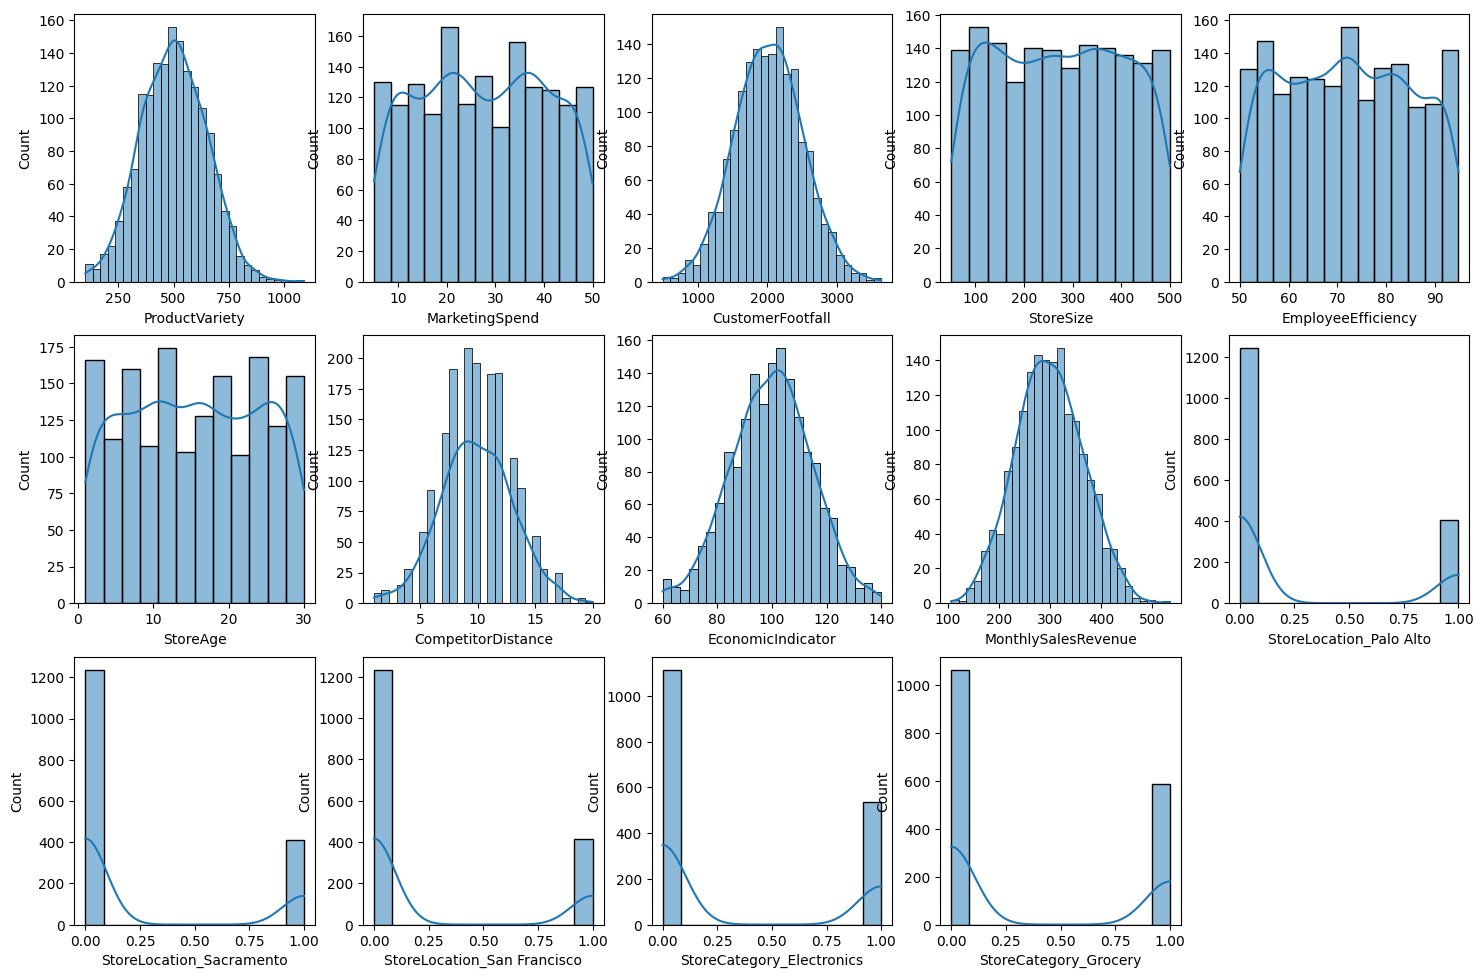

In [ ]:
plt.figure(figsize=(18,16))
for i, col in enumerate(df.columns, 1):
  plt.subplot(4, 5, i)
  sns.histplot(df[col], kde=True)

Các đặc trưng có phân phối chuẩn:
- ProductVariety, CustomerFootFall, CompetitorDistance, EconomicIndicator, MonthlySalesRevenue

TODO: vẽ bảng để xem sự tương quan giữa các đặc trưng với MonthlySalesRevenue

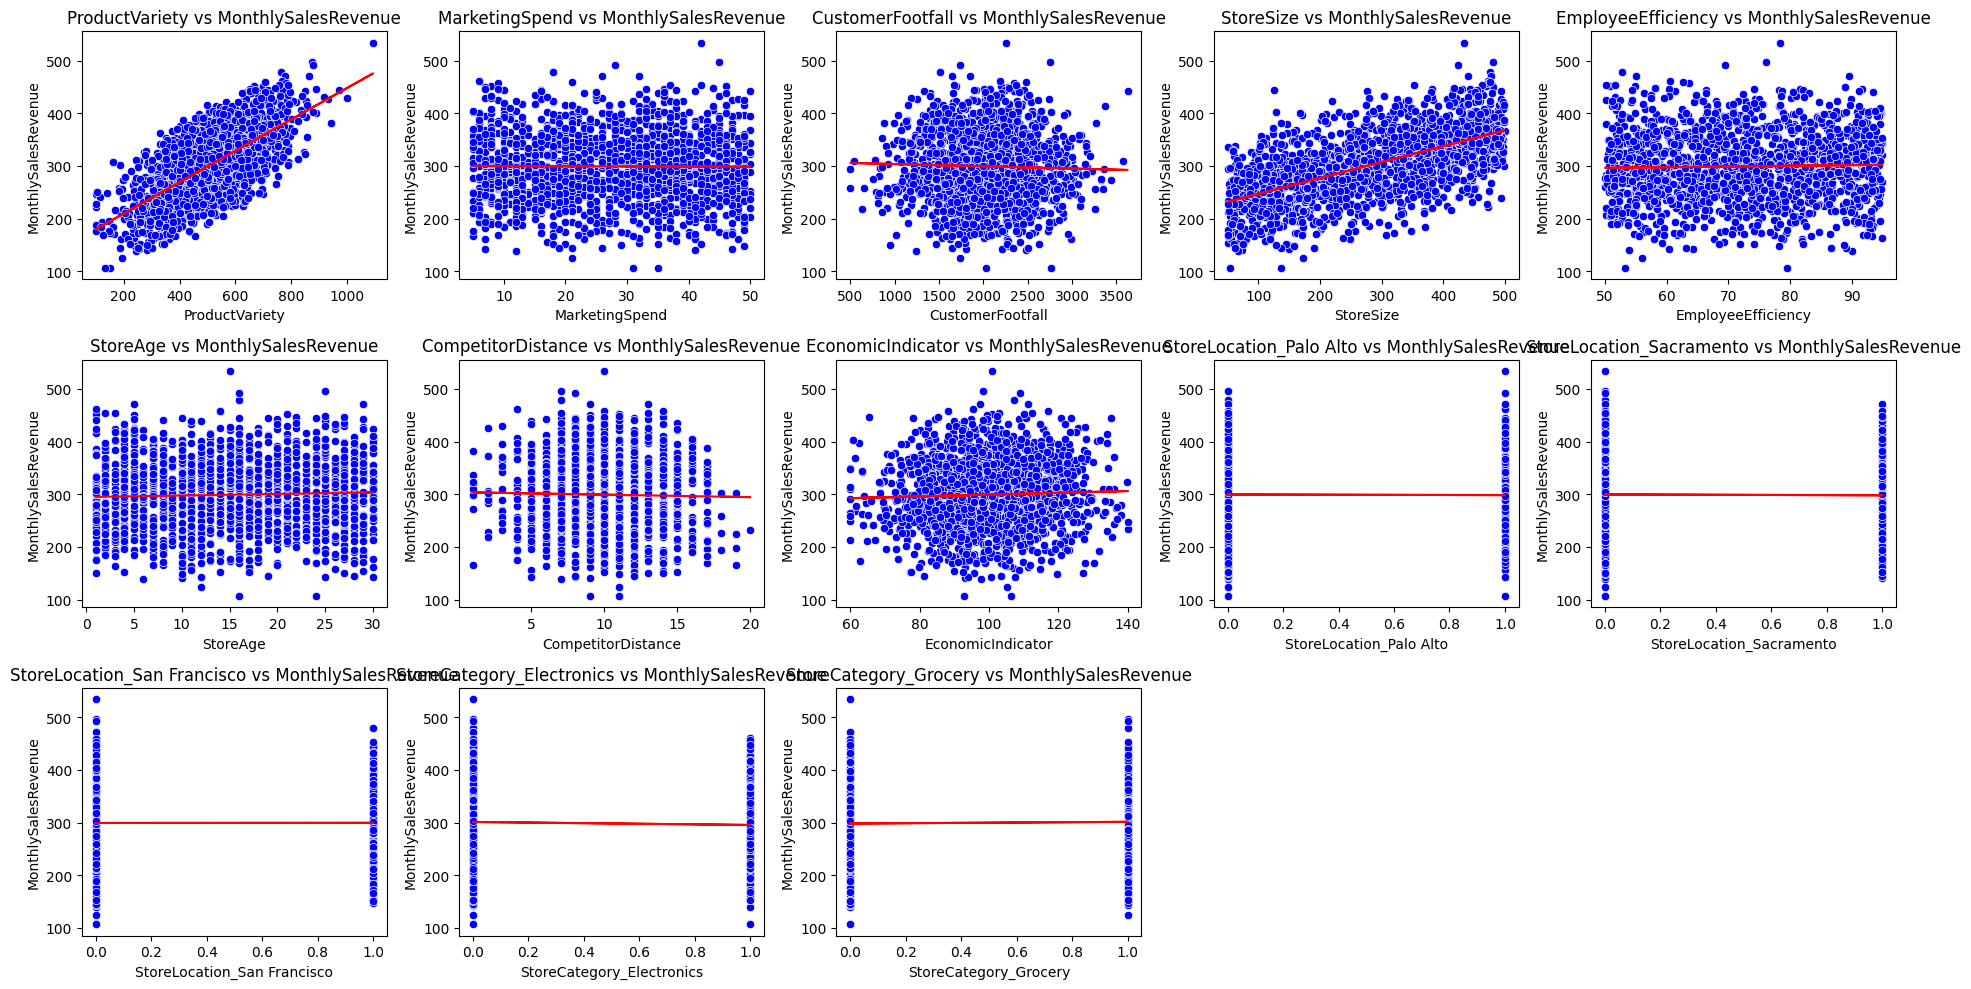

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

plt.figure(figsize=(19, 10))  # Adjust figure size as needed

# Fit a linear regression model to each feature vs MonthlySalesRevenue
for i, col in enumerate(df.columns.drop('MonthlySalesRevenue')):
    plt.subplot(3, 5, i + 1)  # Adjust subplot grid based on number of features
    sns.scatterplot(x=df[col], y=df['MonthlySalesRevenue'], color='blue')

    # Fit a linear regression model for the trend line
    model = LinearRegression()
    model.fit(df[[col]], df['MonthlySalesRevenue'])
    y_pred = model.predict(df[[col]])
    plt.plot(df[col], y_pred, color='red')  # Highlight MonthlySalesRevenue trend

    plt.title(f'{col} vs MonthlySalesRevenue')
    plt.xlabel(col)
    plt.ylabel('MonthlySalesRevenue')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


## Filter-based method


### Information gain (Mutual information)

In [ ]:
X = df.drop(columns=['MonthlySalesRevenue'])
y = df['MonthlySalesRevenue']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Apply Information Gain
ig = mutual_info_regression(X, y)

# Create a dictionary of feature importance scores
feature_scores = {}
for i in range(len(X.columns)):
    feature_scores[X.columns[i]] = ig[i]

# Sort the features by importance score in descending order
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

sorted_features_df = pd.DataFrame(sorted_features, columns=['Feature', 'Score'])
sorted_features_df

,Feature,Score
0,ProductVariety,0.302239
1,StoreSize,0.236889
2,EmployeeEfficiency,0.043537
3,MarketingSpend,0.019500
4,StoreCategory_Grocery,0.017023
5,StoreCategory_Electronics,0.014091
6,StoreAge,0.012820
7,CustomerFootfall,0.006780
8,StoreLocation_San Francisco,0.000097
9,CompetitorDistance,0.000000


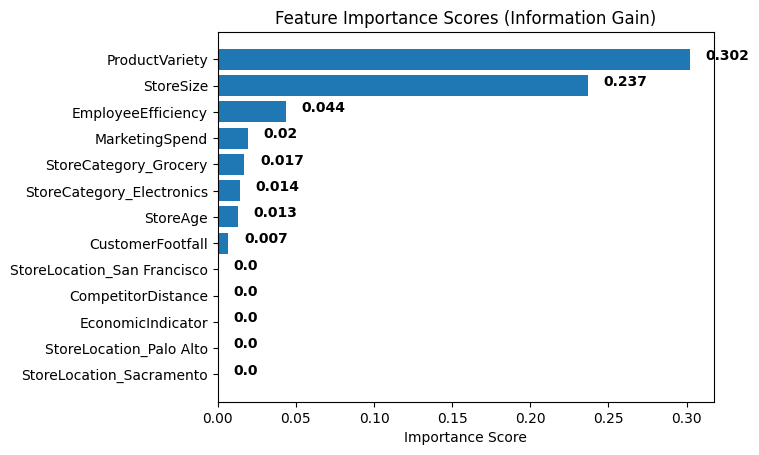

In [ ]:
# Plot a horizontal bar chart of the feature importance scores
fig, ax = plt.subplots()
y_pos = np.arange(len(sorted_features))
ax.barh(y_pos, [score for feature, score in sorted_features], align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels([feature for feature, score in sorted_features])
ax.invert_yaxis()  # Labels read top-to-bottom
ax.set_xlabel("Importance Score")
ax.set_title("Feature Importance Scores (Information Gain)")

# Add importance scores as labels on the horizontal bar chart
for i, v in enumerate([score for feature, score in sorted_features]):
    ax.text(v + 0.01, i, str(round(v, 3)), color="black", fontweight="bold")
plt.show()

Kết quả thu được:
- ProductVariety có điểm quan trọng cao nhất (0.301), cho ta thấy đây là đặc trưng quan trọng nhất trong dataset
- StoreSize có số điểm cao thứ hai (0.237)
- EmployeeEfficiency, StoreCategory có số điểm khá thấp (nhỏ hơn 0.1)
- Các đặc trưng còn lại đều có điểm rất thấp (nhỏ hơn 0.01) nên ta có thể nói những đặc trưng này không có đóng góp hoặc đóng góp rất ít cho dataset

### Pearson Correlation Coefficient

<Axes: >

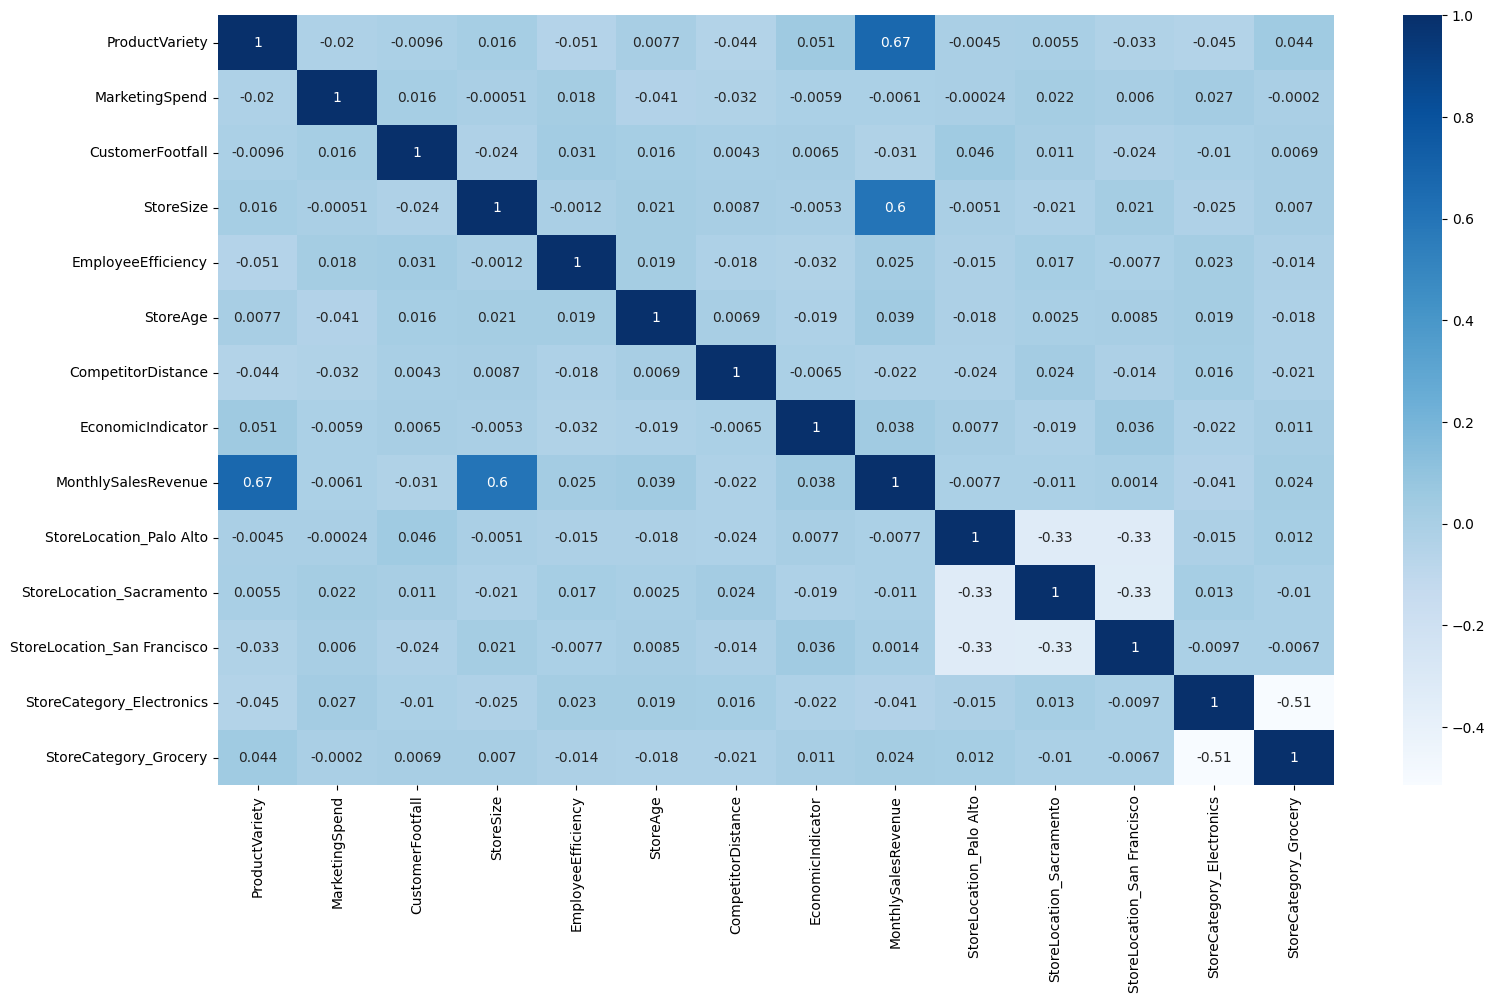

In [ ]:
# Heatmap
plt.figure(figsize=(18,10))
sns.heatmap(df.corr(method='pearson'), cmap='Blues', annot=True)

Kết quả thu được theo Pearson Correlation Coefficient:
- ProductVariety có điểm quan trọng cao nhất (0.67)
- StoreSize có số điểm cao thứ hai (0.6)
- Các đặc trưng còn lại đều có điểm rất thấp (nhỏ hơn 0.1) nên ta có thể nói những đặc trưng này không có đóng góp hoặc đóng góp rất ít cho dataset

## Phương pháp bọc (Wrapper method)

### Sequential Forward Selection

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(y_train.shape)

(1155, 13)
(1155,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

fw_feature_selection = SequentialFeatureSelector(
    LinearRegression(),
    # n_features_to_select='auto', # auto de SFS tu chon va ngung lai khi cac dac trung khac khong co tac dung
    direction='forward',           # forward selection, thay doi thanh backward thi se la backward selection
    cv=5                           # 5-fold cross validation, 5 = default value
)

fw_feature_selection.fit(X_train, y_train)
important_feature_sfs = pd.DataFrame(list(zip(X.columns, fw_feature_selection.get_support())), columns=['feature', 'importance'])
important_feature_sfs.sort_values(by='importance', ascending=False)

,feature,importance
0,ProductVariety,True
1,MarketingSpend,True
3,StoreSize,True
4,EmployeeEfficiency,True
5,StoreAge,True
6,CompetitorDistance,True
2,CustomerFootfall,False
7,EconomicIndicator,False
8,StoreLocation_Palo Alto,False
9,StoreLocation_Sacramento,False


In [ ]:
fw_feature_selection = SequentialFeatureSelector(
    LinearRegression(),
    # n_features_to_select='auto', # auto de SFS tu chon va ngung lai khi cac dac trung khac khong co tac dung
    direction='forward',           # forward selection, thay doi thanh backward thi se la backward selection
    cv=5                           # 5-fold cross validation, 5 = default value
)
fw_feature_selection.fit(X_train, y_train)
important_feature_sfs = pd.DataFrame(list(zip(X.columns, fw_feature_selection.get_support())), columns=['feature', 'importance'])
important_feature_sfs.sort_values(by='importance', ascending=False)

,feature,importance
0,ProductVariety,True
1,MarketingSpend,True
3,StoreSize,True
4,EmployeeEfficiency,True
5,StoreAge,True
6,CompetitorDistance,True
2,CustomerFootfall,False
7,EconomicIndicator,False
8,StoreLocation_Palo Alto,False
9,StoreLocation_Sacramento,False


Kết quả: Có sự khác biệt so với Mutual Information

Khác nhau: Store category đã không còn quan trọng, marketing spend quan trọng hơn store size, competitor distance có ý nghĩa quan trọng đối với kỹ thuật này.

Sự giống nhau: CustomerFootfall, Economic Indicator, Store location không đóng góp trong mô hình

### Recursive Feature Elimination

                        feature  importance
0                ProductVariety           1
3                     StoreSize           2
4            EmployeeEfficiency           3
5                      StoreAge           4
2              CustomerFootfall           5
1                MarketingSpend           6
7             EconomicIndicator           7
10  StoreLocation_San Francisco           8
12        StoreCategory_Grocery           9
6            CompetitorDistance          10
11    StoreCategory_Electronics          11
8       StoreLocation_Palo Alto          12
9      StoreLocation_Sacramento          13
Test R^2 Score with Selected Features: 0.4558066432687883


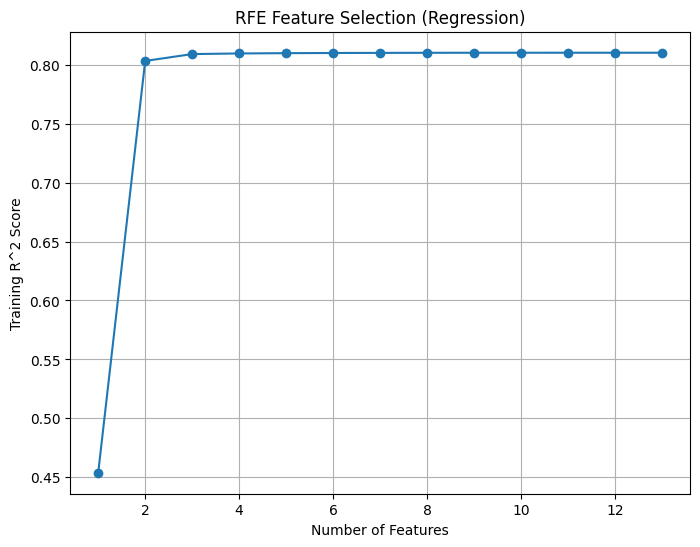

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Define the regression model (Linear Regression in this case)
model = LinearRegression()

# Define the RFE (Recursive Feature Elimination) object
# Here, we set `n_features_to_select=5` to select the top 5 features
rfe = RFE(estimator=model, n_features_to_select=1)

# Perform feature selection with RFE
rfe.fit(X_train, y_train)

# Print the selected features
# print("Selected Features:", X.columns[rfe.support_])  # Show the names of selected features
# print("Feature Ranking:", rfe.ranking_)  # Ranking of all features, where 1 means the most important

rfe_sort = pd.DataFrame(list(zip(X.columns, rfe.ranking_)), columns=['feature', 'importance'])
rfe_sort = rfe_sort.sort_values(by='importance', ascending=True)
print(rfe_sort)

# Evaluate the performance of the selected features on the testing set
X_train_selected = X_train[:, rfe.support_]  # Select the top features based on RFE
X_test_selected = X_test[:, rfe.support_]
model.fit(X_train_selected, y_train)
test_score = model.score(X_test_selected, y_test)

print("Test R^2 Score with Selected Features:", test_score)

# Plot the performance of the model with different feature subsets
# Plotting the number of features vs. R^2 score can give insights into the optimal number of features.
n_features = np.arange(1, X_train.shape[1] + 1)
scores = []
for n in n_features:
    rfe = RFE(estimator=model, n_features_to_select=n)
    rfe.fit(X_train, y_train)
    X_train_selected = X_train[:, rfe.support_]
    model.fit(X_train_selected, y_train)
    score = model.score(X_train_selected, y_train)  # R^2 score
    scores.append(score)

# Plot the performance
plt.figure(figsize=(8, 6))
plt.plot(n_features, scores, marker='o')
plt.xlabel("Number of Features")
plt.ylabel("Training R^2 Score")
plt.title("RFE Feature Selection (Regression)")
plt.grid(True)
plt.show()

RFE đạt cực đại tại 4 với các đặc trưng:  ProductVariety           1
3                     StoreSize           2
4            EmployeeEfficiency           3
5                      StoreAge      

In [ ]:
df.head()

,ProductVariety,MarketingSpend,CustomerFootfall,StoreSize,EmployeeEfficiency,StoreAge,CompetitorDistance,EconomicIndicator,MonthlySalesRevenue,StoreLocation_Palo Alto,StoreLocation_Sacramento,StoreLocation_San Francisco,StoreCategory_Electronics,StoreCategory_Grocery
0,581,29,1723,186,84.9,1,12,108.3,284.90,0.0,0.0,0.0,1.0,0.0
1,382,31,1218,427,75.8,18,11,97.8,308.21,0.0,0.0,0.0,1.0,0.0
2,449,35,2654,142,92.8,14,11,101.1,292.11,0.0,0.0,0.0,0.0,1.0
3,666,9,2591,159,66.3,11,11,115.1,279.61,0.0,1.0,0.0,0.0,0.0
4,657,35,2151,275,89.1,28,12,93.4,359.71,1.0,0.0,0.0,1.0,0.0


6 đặc trưng quan trọng nhất theo RFE là 'ProductVariety', 'EmployeeEfficiency', 'StoreLocation_San Francisco', 'StoreCategory_Electronics', 'StoreCategory_Grocery', 'StoreLocation_Palo Alto'

Điểm R^2 cho thấy mô hình nên có từ 5 đến 6 đặc trưng là tốt nhất

## Phương pháp nhúng (Embedded Approach)

### ElasticNet

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Tao model ElasticNetCV
elastic = ElasticNetCV(
    l1_ratio = 0.7,    # Lasso = 0.7, Ridge = 0.3
    random_state=42,
    cv=5,              # 5-fold CV
    verbose=1,
)
elastic.fit(X_train, y_train)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ElasticNetCV(cv=5, l1_ratio=0.7, random_state=42, verbose=1)

In [ ]:
fi = [(feature, coef) for (feature, coef) in zip(X.columns, elastic.coef_)]
fi_pd = pd.DataFrame(fi, columns=['feature', 'importance'])
fi_pd.sort_values(by='importance', ascending=False)

,feature,importance
4,EmployeeEfficiency,0.324757
0,ProductVariety,0.296240
3,StoreSize,0.294557
5,StoreAge,0.043954
1,MarketingSpend,0.001121
9,StoreLocation_Sacramento,-0.000000
6,CompetitorDistance,0.000000
7,EconomicIndicator,0.000000
8,StoreLocation_Palo Alto,-0.000000
11,StoreCategory_Electronics,0.000000


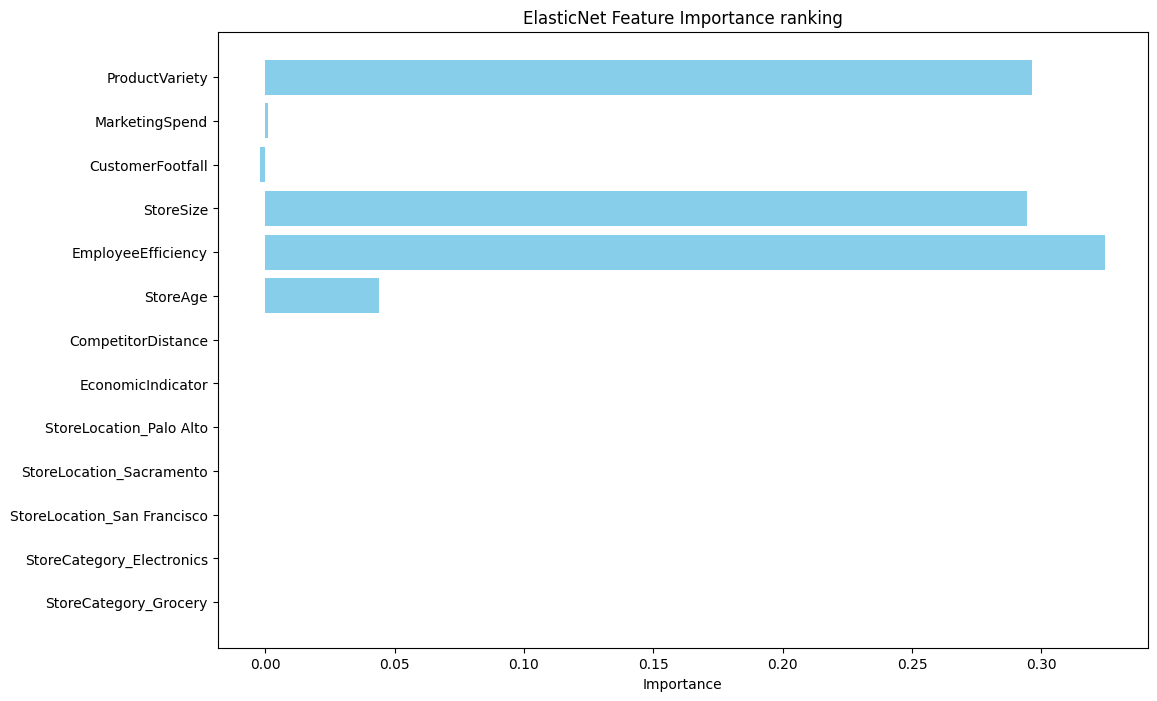

In [ ]:
plt.figure(figsize=(12,8))
plt.title("ElasticNet Feature Importance ranking")
plt.xlabel('Importance')
plt.barh(fi_pd['feature'], fi_pd['importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.show()

# co gia tri am nen nhin ko dep lam

Vậy các đặc trưng quan trọng được chọn bởi ElasticNet có 4 đặc trưng cao điểm nhất:

-Product Variety

-Store Size

-Employee effeciency

-Store Age với số điểm khá thấp

### Random Forest Importance


                        Feature  Importance
0                ProductVariety    0.475256
3                     StoreSize    0.386434
4            EmployeeEfficiency    0.029972
2              CustomerFootfall    0.021982
7             EconomicIndicator    0.020394
5                      StoreAge    0.020116
1                MarketingSpend    0.018594
6            CompetitorDistance    0.013941
12        StoreCategory_Grocery    0.003042
9      StoreLocation_Sacramento    0.002731
8       StoreLocation_Palo Alto    0.002657
10  StoreLocation_San Francisco    0.002572
11    StoreCategory_Electronics    0.002309


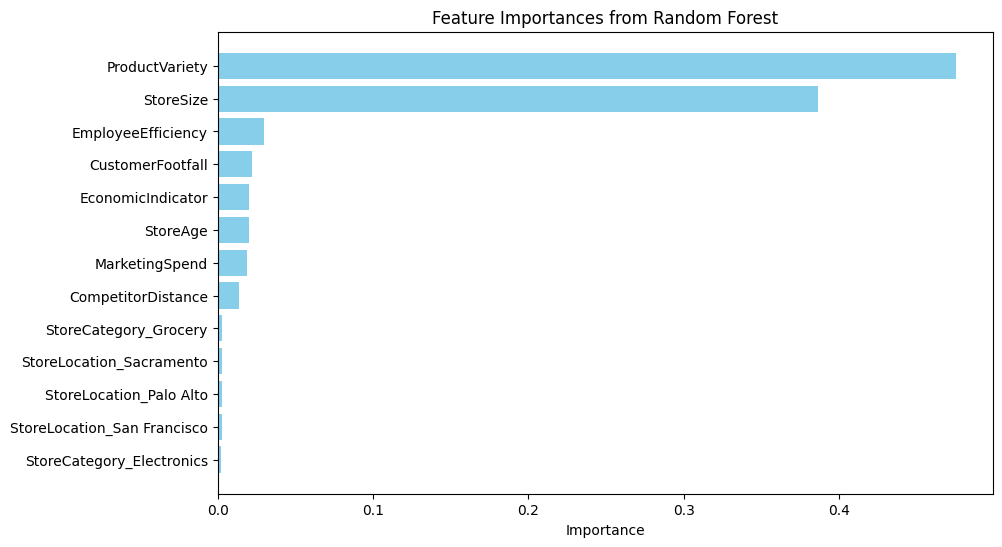

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor  # Use RandomForestClassifier for classification
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Get the feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance (from most important to least important)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

RF chọn ProductVariety và StoreSize
Các đặc trưng còn lại điểm rất thấp dưới 0.1

## Tiểu kết

Qua các bước phân tích trên, ta thấy được có 2 đặc trưng quan trọng không thể loại bỏ là Product Variety và Store Size

Bước tiếp theo, chúng ta sẽ tạo một mô hình linear regression baseline với đủ các đặc trưng ban đầu và so sánh chúng với các mô hình đã được chọn lọc đặc trưng như ta đã làm ở bước trên.

# Huấn luyện mô hình

## Mô hình base

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/dataset/Store_CA.csv")

# One-Hot Encoding
# Create a OneHotEncoder object
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)  # sparse=False for dense output

# Fit and transform the 'StoreLocation' and 'StoreCategory' columns
encoded_features = ohe.fit_transform(data[['StoreLocation', 'StoreCategory']])

# Create a new DataFrame from the encoded features
encoded_data = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(['StoreLocation', 'StoreCategory']))

# Drop the original categorical columns from X
data = data.drop(columns=['StoreLocation', 'StoreCategory'])

# Concatenate the encoded features with the remaining features
data = pd.concat([data, encoded_data], axis=1)

# Define X and y
X = data.drop(columns=['MonthlySalesRevenue'])
y = data['MonthlySalesRevenue']

#scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the logistic regression model
base_model = LinearRegression()
base_model.fit(X_train, y_train)

LinearRegression()

Mean Squared Error: 830.2908639672511


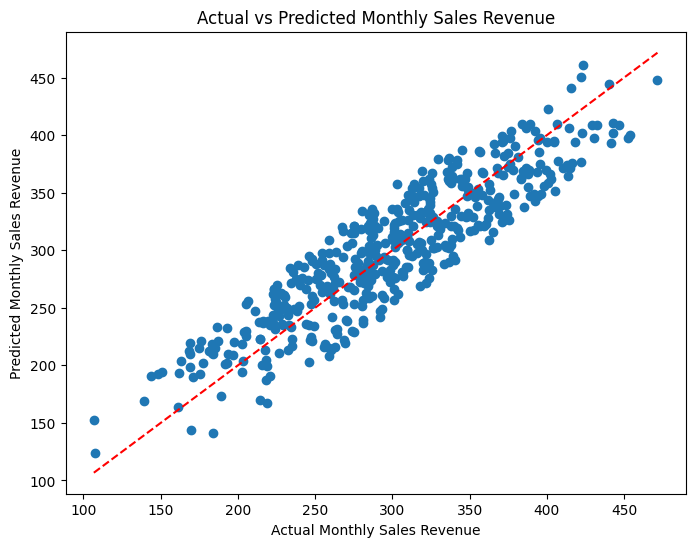

In [ ]:
# Make predictions on the test set
y_pred = base_model.predict(X_test)

#Tinh mse
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot the predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Monthly Sales Revenue")
plt.ylabel("Predicted Monthly Sales Revenue")
plt.title("Actual vs Predicted Monthly Sales Revenue")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Add a diagonal line
plt.show()

Kết quả của Base model cho thấy mô hình hồi quy đang hoạt động tốt. Các giá trị thực tế và dự đoán được liên kết chặt chẽ với nhau, ngụ ý rằng mô hình đang nắm bắt mối quan hệ giữa các đặc trưng và biến target (MonthlySaleRevenue) một cách hiệu quả.

In [ ]:
# Lưu kết quả base model
def base_model_result(a,b):
    return base_model_mse,base_model_r2
base_model_mse = mse
base_model_r2 = r2_score(y_test, y_pred)  # tính R2 cho base model

In [ ]:
#filter Base method
# ft theo Mutual Information
col_fi = ['ProductVariety', 'StoreSize', 'EmployeeEfficiency', 'MarketingSpend', 'StoreCategory_Grocery', 'StoreAge']
# ft theo Pearson
col_pearson = ['ProductVariety', 'StoreSize']

#Wrapper Method
# ft theo Forward Selection
col_fw = ['ProductVariety', 'MarketingSpend', 'StoreSize', 'EmployeeEfficiency', 'StoreAge', 'CompetitorDistance']
# ft theo RFE
col_rfe = ['ProductVariety', 'EmployeeEfficiency', 'StoreLocation_San Francisco', 'StoreCategory_Electronics', 'StoreCategory_Grocery']

#Embedded Method
# ft theo ElasticNetCV
col_elastic =['ProductVariety', 'StoreSize', 'EmployeeEfficiency', 'StoreAge']
# ft theo Random Forest Importance
col_rf = ['ProductVariety', 'StoreSize', 'EmployeeEfficiency', 'CustomerFootfall', 'EconomicIndicator', 'StoreAge', 'MarketingSpend', 'CompetitorDistance']




Chưa làm: train một model bình thường với đầy đủ đặc trưng, train tiếp các model khác CHỈ VỚI các cột trên đã tìm được, sau đó so sánh các kết quả với nhau.


In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, feature_set):
    # Train the model
    model.fit(X_train[feature_set], y_train)

    # Predict on the testing set
    y_pred = model.predict(X_test[feature_set])

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2

# Evaluate the model with different feature subsets

scores = {
    'Base Model': base_model_result(base_model_mse,base_model_r2),
    'Mutual Information': evaluate_model(model, X_train, X_test, y_train, y_test,col_fi),
    'Pearson': evaluate_model(model, X_train, X_test, y_train, y_test,col_pearson),
    'Forward Selection': evaluate_model(model, X_train, X_test, y_train, y_test,col_fw),
    'RFE': evaluate_model(model, X_train, X_test, y_train, y_test,col_rfe),
    'ElasticNetCV': evaluate_model(model, X_train, X_test, y_train, y_test, col_elastic),
    'Random Forest Importance': evaluate_model(model, X_train, X_test, y_train, y_test,col_rf),
}


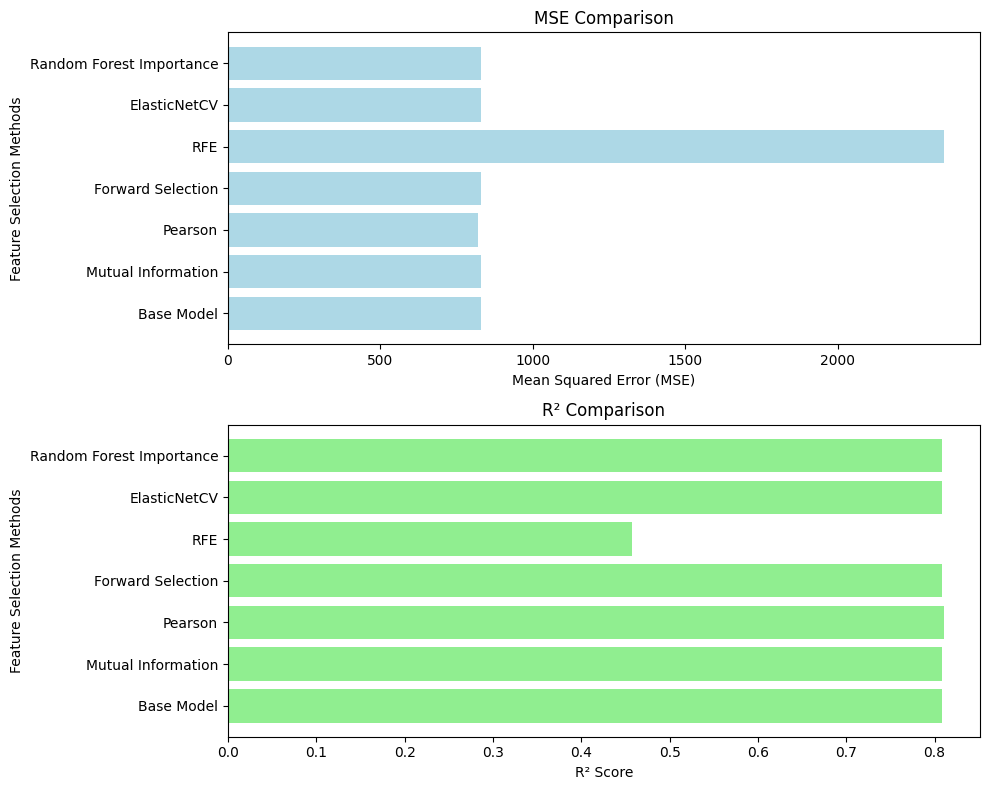

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Giả sử bạn đã chạy hàm evaluate_model và có kết quả lưu trong 'scores'
methods = list(scores.keys())
mse_scores = [score[0] for score in scores.values()]
r2_scores = [score[1] for score in scores.values()]

# Tạo figure với 2 biểu đồ nằm ngang (subplots) để so sánh MSE và R²
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Vẽ biểu đồ MSE (nằm trên cùng)
ax[0].barh(methods, mse_scores, color='lightblue')
ax[0].set_title('MSE Comparison')
ax[0].set_xlabel('Mean Squared Error (MSE)')
ax[0].set_ylabel('Feature Selection Methods')

# Vẽ biểu đồ R² (nằm dưới)
ax[1].barh(methods, r2_scores, color='lightgreen')
ax[1].set_title('R² Comparison')
ax[1].set_xlabel('R² Score')
ax[1].set_ylabel('Feature Selection Methods')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


## TIỂU KẾT

Điểm R^2 và MSE cho thấy set đặc trưng của RFE cho ra kết quả không tốt.

Các set đặc trưng còn lại cho ra hiệu suất gần như đồng nhất với BASE mặc dù số lượng đặc trưng được chọn ít hơn ít nhất là gấp đôi so với BASE.

Qua đó cho thấy chúng ta đã giảm thiểu được các đặc trưng không cần thiết mà vẫn giữ được hiệu suất của mô hình.

# KẾT LUẬN

Điểm đặc biệt ở đây là phương pháp Pearson chỉ có 2 đặc trưng nhưng vẫn giữ được hiệu suất dự đoán không thua kém các mô hình khác. Tại sao?

Thông qua các bước EDA cũng như chọn lựa Feature Importance theo nhiều cách, ta thấy được 2 đặc trưng ProductVariety và StoreSize luôn xuất hiện ở top đầu trong các mô hinh, điều đó cho thấy đây là 2 đặc trưng quan trọng nhất có sức ảnh hưởng đến biến mục tiêu, vậy nên **ở bài toán này ta có thể loại bỏ 10/12 cột tức hơn 80% dữ liệu mà vẫn không làm giảm hiệu suất của mô hình.**

In [ ]:
# 4. Cross-Validation cho mô hình tốt nhất (ví dụ ElasticNet)
final_model = ElasticNet(alpha=1.0, l1_ratio=0.5)
cv_scores = cross_val_score(final_model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')

print("\nCross-Validation Results:")
print(f"MSE Scores: {-cv_scores}")
print(f"Mean MSE: {-np.mean(cv_scores)}")
print(f"Standard Deviation: {np.std(cv_scores)}")


Cross-Validation Results:
MSE Scores: [1164.26511413 1288.56721313 1188.07901032 1211.51093267 1281.29757339]
Mean MSE: 1226.7439687287579
Standard Deviation: 49.857478873279184


# Các phương pháp không sử dụng được cho dataset này

- Chi-square: chỉ sử dụng được cho các dataset có chủ yếu các đặc trưng phân loại
- Gini-impurity: thường chỉ sử dụng cho các bài toán phân loại, đặc biệt là sử dụng Decision Tree
- Các phương pháp phân cụm

#END